# Quickstart

This package is meant to get you from chromatogram to quantified peaks as rapidly 
as possible. Below is a brief example of how to go from a raw, off-the-machine 
data set to a list of compounds and their absolute concentrations.   

In [253]:
import hplc.quant
import hplc.io
import importlib
importlib.reload(hplc.quant)
importlib.reload(hplc.io)


<module 'hplc.io' from '/Users/gchure/Dropbox/git/postdoc_projects/hplc-py/hplc/io.py'>

## Loading and viewing chromatograms
Text files containing chromatograms with time and signal information can be intelligently read into a pandas DataFrame using `hplc.io.load_chromatogram()`.

In [254]:
# Load the chromatogram as a dataframe
df = hplc.io.load_chromatogram('data/sample.txt', 
                                 colnames=['R.Time (min)', 'Intensity'])
df.head()

,R.Time (min),Intensity
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


By providing the column names as a dictionary, you can rename the (often annoying)
default column names to something easier to work with, such as "time" and "signal"
as 

In [255]:
# Load chromatogram and rename the columns
df = hplc.io.load_chromatogram('data/sample.txt', colnames={'R.Time (min)':'time',
                                                              'Intensity': 'signal'})
df.head()

,time,signal
0,0.00000,0
1,0.00833,0
2,0.01667,0
3,0.02500,0
4,0.03333,-1


This dataframe can now be loaded passed to the `Chromatogram` class, which 
has a variety of methods for quantification, cropping, and visualization and
more.

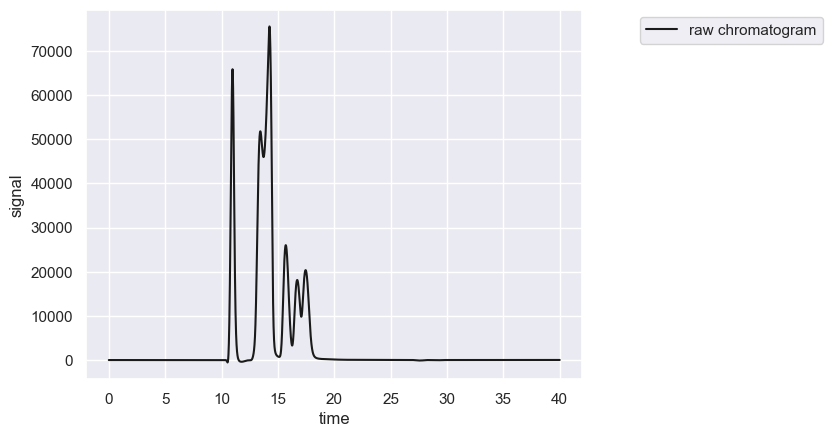

In [256]:
# Instantiate the Chromatogram class with the loaded chromatogram.
chrom = hplc.quant.Chromatogram(df)

# Show the chromatogram
_ = chrom.show()


The `crop` method allows you to crop the chromatogram *in place* to restrict
the signal to a specific time range.  


[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

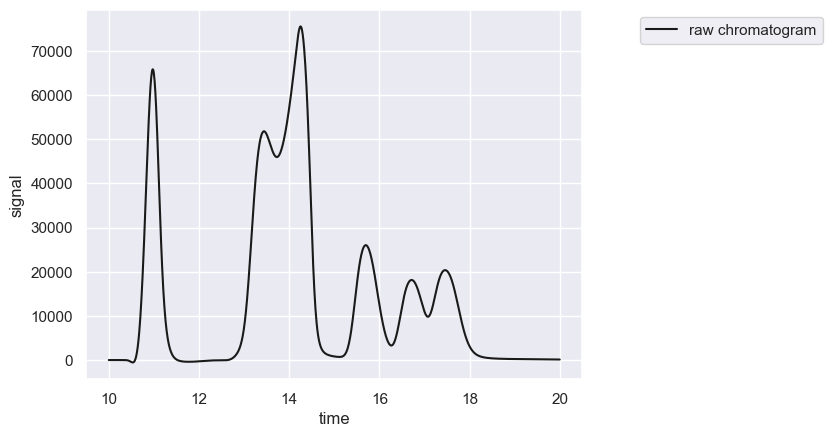

In [257]:
# Crop the chromatogram in place between 8 and 21 min.
chrom.crop([10, 20])
chrom.show()

Note that the crop function operates **in place** and modifies the loaded as data
within the `Chromatogram` object.

## 

# Detecting and Quantifying Peaks
The real meat of the package comes in the deconvolution of signal into discrete
peaks and measurement of their properties. Described in more detail in **XXX**,
this typically involves the automated estimation and subtraction of the baseline,
detection of peaks, and fitting of skew-normal distributions to reconstitute the 
signal. Luckily for you, all of this is done in a single method call `Chromatogram.fit_peaks()`

In [258]:
# Automatically detect and fit the peaks 
peaks = chrom.fit_peaks()
peaks

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  9.41it/s]


,retention_time,scale,skew,amplitude,area,peak_id
0,10.904346,0.157576,0.677681,23248.375233,2.789805e+06,1
0,13.170582,0.582447,3.836861,42222.313082,5.066678e+06,2
0,14.447599,0.353161,-3.019937,35249.388929,4.229927e+06,3
0,15.531862,0.312374,1.629658,14881.173269,1.785741e+06,4
0,16.522672,0.342696,1.969566,10736.906034,1.288429e+06,5
0,17.293670,0.341221,1.616547,12411.399410,1.489368e+06,6


To see how well the deconvolution worked, you can once again call the `show` method
to see the composite compound chromatograms.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

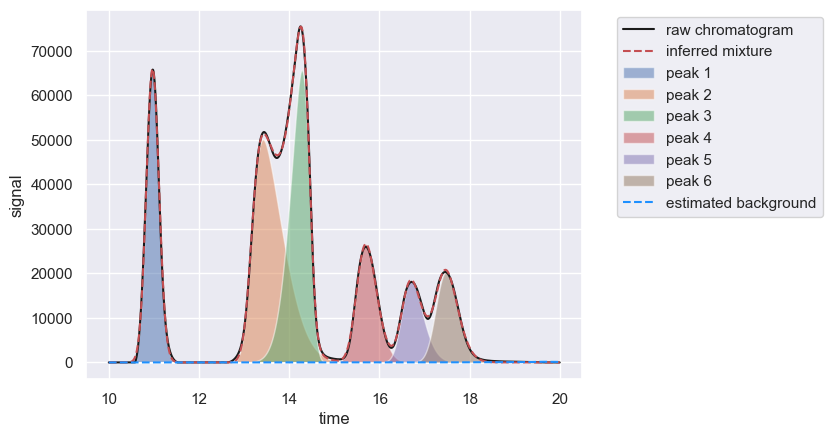

In [259]:
# View the result of the fitting. 
chrom.show()

If you know the parameters of the linear calibration curve, you can use the 
`map_compounds` method which will map user provided compound names 
to peaks.

In [260]:
# Define the two peaks of interest and their calibration curves
calibration = {'compound A': {'retention_time': 15.5,
                              'slope': 10547.6,
                              'intercept': -205.6,
                              'unit': 'µM'},
               'compound B': {'retention_time': 17.2,
                              'slope': 26401.2,
                              'intercept': 54.2,
                              'unit': 'nM'}}
quant_peaks = chrom.map_compounds(calibration)
quant_peaks

,retention_time,scale,skew,amplitude,area,peak_id,compound,concentration,unit
0,15.531862,0.312374,1.629658,14881.173269,1.785741e+06,4,compound A,169.322537,µM
0,17.293670,0.341221,1.616547,12411.399410,1.489368e+06,6,compound B,56.410835,nM


Successfully mapping compounds to peak ID's will also be reflected in the `show`
method.

[<Figure size 640x480 with 1 Axes>, <Axes: xlabel='time', ylabel='signal'>]

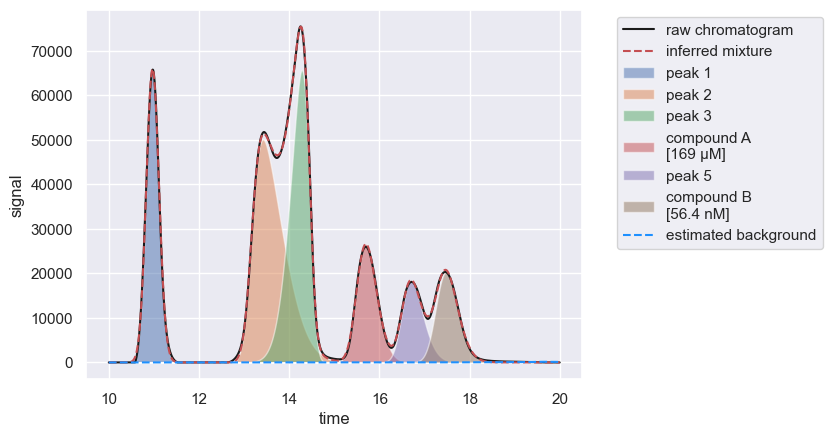

In [261]:
# Show the chromatogram with mapped compounds
chrom.show()

This method returns a Pandas DataFrame that lists each detected peak and its various parameters. Importantly, it
returns the peak area which 

In [6]:
kchrom.window_df

,time,signal,estimated_background,time_idx,window_idx
1790,14.91667,986.281300,4.718700,1790,1.0
1791,14.92500,964.271893,4.728107,1791,1.0
1792,14.93333,944.262349,4.737651,1792,1.0
1793,14.94167,925.252667,4.747333,1793,1.0
1794,14.95000,906.242841,4.757159,1794,1.0
...,...,...,...,...,...
2195,18.29167,649.208736,15.791264,2195,3.0
2196,18.30000,630.186103,15.813897,2196,3.0
2197,18.30833,612.163010,15.836990,2197,3.0
2198,18.31667,594.140435,15.859565,2198,3.0


/var/folders/n5/tr_m46z93v7gx5bxc60w2mt80000gn/T/ipykernel_82677/1740735647.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in chrom.window_df.groupby(['window_idx']):


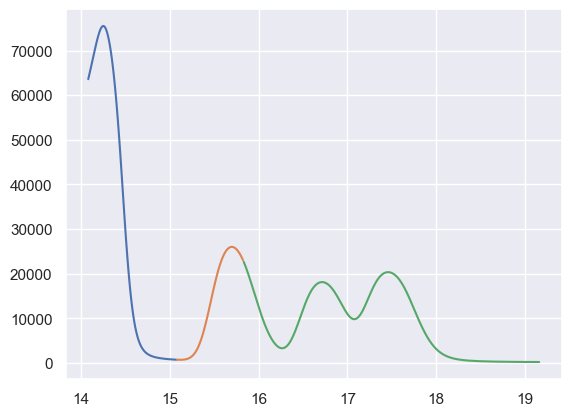

In [26]:
import matplotlib.pyplot as plt
for g, d in chrom.window_df.groupby(['window_idx']):
    plt.plot(d['time'], d['signal'])

In [53]:
import importlib
import hplc.quant
import hplc.io
import matplotlib.pyplot as plt
importlib.reload(hplc.quant)
importlib.reload(hplc.io)
# Instantiate the Chromatogram class with the loaded chromatogram.
df = hplc.io.load_chromatogram('data/sample.txt', colnames={'R.Time (min)':'time',
                                                              'Intensity': 'signal'})
chrom = hplc.quant.Chromatogram(df)

# Show the chromatogram
chrom.crop([10, 20])
# locs = [-]
peaks = chrom.fit_peaks(enforced_locations=[15.75, 16.75, 17.5], approx_peak_width=1.5)
# chrom.show()

Deconvolving mixture: 100%|██████████| 2/2 [00:00<00:00,  6.92it/s]


/var/folders/n5/tr_m46z93v7gx5bxc60w2mt80000gn/T/ipykernel_88035/411123135.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for g, d in chrom.window_df.groupby(['window_idx']):


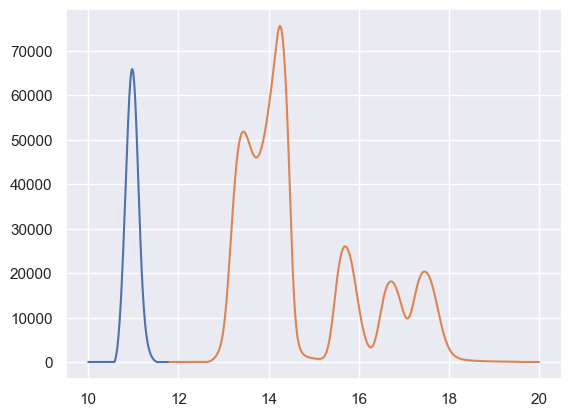

In [43]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 3)
for g, d in chrom.window_df.groupby(['window_idx']):
    plt.plot(d['time'], d['signal'])

In [64]:
chrom._peak_indices

array([690, 810, 900])

In [31]:
hkkchrom._ranges

[array([1790, 1791, 1792, 1793, 1794, 1795, 1796, 1797, 1798, 1799, 1800,
        1801, 1802, 1803, 1804, 1805, 1806, 1807, 1808, 1809, 1810, 1811,
        1812, 1813, 1814, 1815, 1816, 1817, 1818, 1819, 1820, 1821, 1822,
        1823, 1824, 1825, 1826, 1827, 1828, 1829, 1830, 1831, 1832, 1833,
        1834, 1835, 1836, 1837, 1838, 1839, 1840, 1841, 1842, 1843, 1844,
        1845, 1846, 1847, 1848, 1849, 1850, 1851, 1852, 1853, 1854, 1855,
        1856, 1857, 1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866,
        1867, 1868, 1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877,
        1878, 1879, 1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888,
        1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899,
        1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
        1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
        1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
        1933, 1934, 1935, 1936, 1937, 

/var/folders/n5/tr_m46z93v7gx5bxc60w2mt80000gn/T/ipykernel_82677/1449624587.py:4: PeakPropertyWarning: some peaks have a prominence of 0
  widths, _, _, _, = scipy.signal.peak_widths(intensity, chrom._peak_indices, rel_height=0.5)
/var/folders/n5/tr_m46z93v7gx5bxc60w2mt80000gn/T/ipykernel_82677/1449624587.py:4: PeakPropertyWarning: some peaks have a width of 0
  widths, _, _, _, = scipy.signal.peak_widths(intensity, chrom._peak_indices, rel_height=0.5)


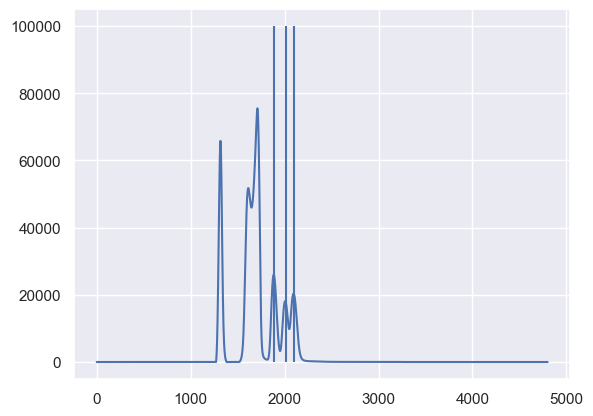

In [24]:
import scipy.signal
chrom._peak_indices
intensity = chrom.df['signal'].values
widths, _, _, _, = scipy.signal.peak_widths(intensity, chrom._peak_indices, rel_height=0.5)
plt.plot(intensity)
plt.vlines(chrom._peak_indices, 0, 1E5)

(10.0, 20.0)

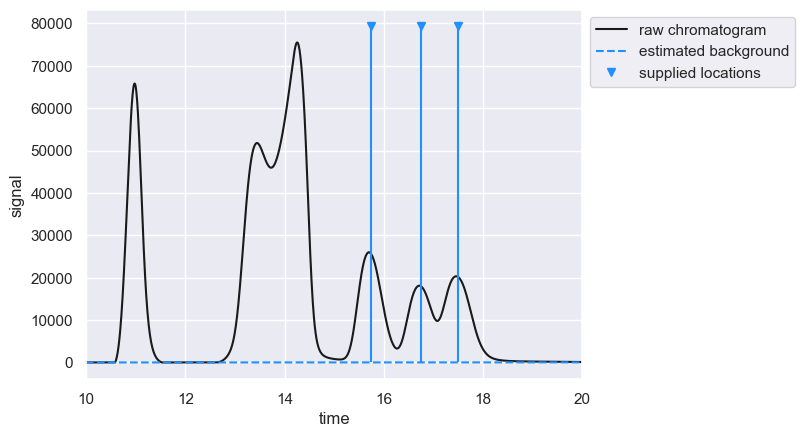

In [25]:
fig, ax = chrom.show()
ax.set_xlim(10, 20)

In [8]:
chrom.detect_peaks()

AttributeError: 'Chromatogram' object has no attribute 'detect_peaks'

Column names can be automatically renamed to your liking by passing `colnames`
to `load_chromatogram()` as a dictionary.

(10.0, 20.0)

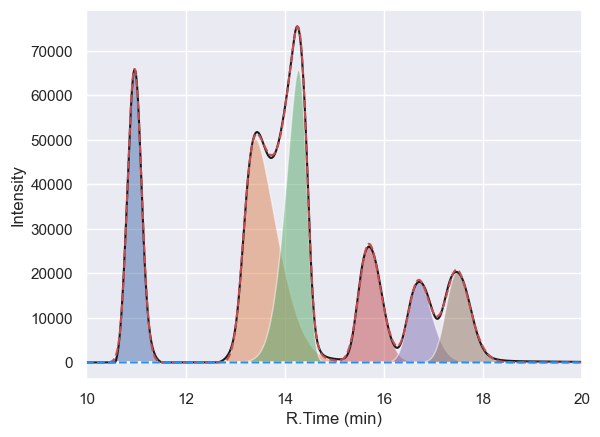

In [16]:
fig, ax = chrom.show()
ax.set_xlim(10, 20)

In [11]:
import numpy as np 
import pandas as pd

def load_chromatogram(fname, colnames=[], delimiter=',', dropna=False):
    R"""
    Parses a file containing a chromatogram and returns it as a Pandas DataFrame.

    Parameters 
    -----------
    fname: `str`
        The path to the file containing the chromatogram. This must be a text
        file (i.e. not `.xslx`!) 
    colnames : `list` or `dict`
        The desired columns present in the file. If provided as a dict, columns will
        be renamed as `key` -> `value`. If not provided, it will be assumed 
        that the chromatogram begins without needing to skip any lines. 
    delimiter : 'str' 
        The delimiter character separating columns in the chromatogram.
    dropna: `bool`
        If True, NaN's will be dropped from the chromatogram.  

    Returns
    -------
    df : `pandas.core.frame.DataFrame`
        The chromatogram loaded as a Pandas DataFrame with the desired columns.
    """
    if type(colnames) != dict:
        _colnames = list(colnames.keys())
    else:
        _colnames = colnames
    skip = 0
    if len(_colnames) != 0:
        with open(fname, 'r') as f:
            _lines = f.readlines()
            halted = False
            for line in _lines:   
                if np.array([nom.lower() in line.lower() for nom in _colnames]).all():
                    halted = True
                    break
                else:
                    skip += 1
            if not halted:
                raise ValueError("Provided column name(s) were not found in file. Check spelling?")

    # Given skips, load in dataframe and rename if necessary
    df = pd.read_csv(fname, skiprows=skip, delimiter=delimiter)
    if type(colnames) == dict:
        df.rename(columns=colnames, inplace=True)
        _colnames = list(colnames.values())
    if dropna:
        df.dropna(inplace=True)

    # Keep only the desired columns.
    df = df[_colnames]
    return df
    

                



In [13]:
load_chromatogram('data/sample.txt', colnames={'R.Time (min)':'time_min'})

,time_min
0,0.00000
1,0.00833
2,0.01667
3,0.02500
4,0.03333
...,...
4796,39.96667
4797,39.97500
4798,39.98333
4799,39.99167


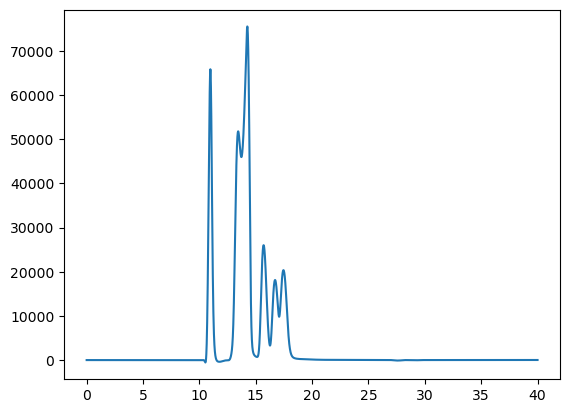

In [47]:
import matplotlib.pyplot as plt 
plt.plot(df['time_min'], df['intensity_mV'])

In [16]:
f = 'Test this line'
names = ['this', 'line', 'Test']
'test' in f.lower()

True

In [18]:
z[:10]

['[Header]\n',
 'Application Name,LabSolutions\n',
 'Version,5.97 SP1\n',
 'Data File Name,C:\\Users\\cremerlab\\Desktop\\Richa\\June 30th 2023 ECOR_yield_Mal_and_Fru_calibration_curves\\June30th 2023_6302023_015_016.lcd\n',
 'Output Date,7/1/2023\n',
 'Output Time,5:23:44 AM\n',
 '\n',
 '[File Information]\n',
 'Type,Data File\n',
 'Generated,7/1/2023 4:43:22 AM\n']

In [ ]:
def load_chromatogram(fname, colnames=[], )